<h3>Import libraries</h3>

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # you can also use tensorflow or torch

#import keras_cv
#import keras
#from keras import ops
#import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import math

#print("TensorFlow:", tf.__version__)
# print("Keras:", keras.__version__)
# print("KerasCV:", keras_cv.__version__)

<h3>Config</h3>

In [2]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    # preset = "mobilenet_v3_large_imagenet"  # Name of pretrained classifier
    image_size = [224, 224]  # Input image size
    epochs = 1 # 12 # Training epochs
    batch_size = 16 # 96  # Batch size
    lr_mode = "step" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    num_folds = 5 # Number of folds to split the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['X4_mean', 'X11_mean', 'X18_mean',
                   'X26_mean', 'X50_mean', 'X3112_mean',]
    aux_class_names = list(map(lambda x: x.replace("mean","sd"), class_names))
    num_classes = len(class_names)
    aux_num_classes = len(aux_class_names)

BASE_PATH = "../data"

<h3>Load and process data set</h3>

In [3]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = f'{BASE_PATH}/train_images/'+df['id'].astype(str)+'.jpeg'
df.loc[:, CFG.aux_class_names] = df.loc[:, CFG.aux_class_names].fillna(-1)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['image_path'] = f'{BASE_PATH}/test_images/'+test_df['id'].astype(str)+'.jpeg'
FEATURE_COLS = test_df.columns[1:-1].tolist()
display(test_df.head(2))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,../data/train_images/192027691.jpeg
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,../data/train_images/195542235.jpeg


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,image_path
0,201238668,8.086756,2246.500000,127.321426,20.423418,353.381042,17.535713,80,109,90,...,0.389460,0.387536,0.374910,0.363712,0.364623,0.379435,0.388294,0.398887,0.397853,../data/test_images/201238668.jpeg
1,202310319,10.844286,495.871429,28.023809,18.738306,786.554382,29.292856,130,155,142,...,0.300813,0.332776,0.314386,0.291168,0.280947,0.277623,0.276503,0.271212,0.272672,../data/test_images/202310319.jpeg


In [4]:
import torch
from torchvision import transforms
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import os


def build_augmenter():

    # Define augmentations
    aug_layers = nn.ModuleList([
        transforms.ColorJitter(brightness=0.1),
        transforms.ColorJitter(contrast=0.1),
        transforms.ColorJitter(saturation=(0.45, 0.55)),
        transforms.ColorJitter(hue=0.1),
        transforms.RandomErasing(scale=(0.06, 0.15)),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=(CFG.image_size[0], CFG.image_size[1]), scale=(0.05, 0.15)),
        transforms.RandomRotation(degrees=(0.6, 3.0)), # approx multiplied by 360/2pi since keras works in radians while this works in degrees
    ])
    
    # Build augmenter, randomly applying augmentations
    augmenter = transforms.RandomApply(aug_layers, p=0.5)
                  
    # Apply augmentations
    def augment(inp, label):
        aug_data = {"images": augmenter(inp["images"])}
        inp["images"] = aug_data["images"]
        return inp, label
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        path = inp["images"]
        
        # Read jpeg image
        image = Image.open(path)

        # Resize and convert to tensor
        transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),
        ])
        image = transform(image)
        
        # Rescale image
        image = image.float()
        image /= 255.0
        
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = torch.tensor(label).float()
        label = label.view(num_classes)
        return label

    def decode_with_labels(inp, labels=None):
        inp = decode_image(inp)
        label = decode_label(labels[0], CFG.num_classes)
        aux_label = decode_label(labels[1], CFG.aux_num_classes)
        return (inp, (label, aux_label))

    return decode_with_labels if with_labels else decode_image

class CustomDataset(Dataset):
    def __init__(self, paths, features, labels=None, aux_labels=None, decode_fn=None, augment_fn=None, augment=False):
        self.paths = paths
        self.features = features
        self.labels = labels
        self.aux_labels = aux_labels
        self.decode_fn = decode_fn
        self.augment_fn = augment_fn
        self.augment = augment

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        inp = {"images": self.paths[idx], "features": self.features[idx]}
        if self.labels is not None:
            slices = self.decode_fn(inp, (self.labels[idx], self.aux_labels[idx]))
            if self.augment:
                slices = self.augment_fn(inp, (self.labels[idx], self.aux_labels[idx]))
        else:
            slices = self.decode_fn(inp)
            if self.augment:
                slices = self.augment_fn(inp)

        return slices

def build_dataset(
    paths,
    features,
    labels=None,
    aux_labels=None,
    batch_size=32,
    cache=True,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    repeat=True,
    shuffle=1024,
    cache_dir="",
    drop_remainder=False,
):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None or aux_labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    dataset = CustomDataset(paths, features, labels, aux_labels, decode_fn, augment_fn, augment)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=bool(shuffle), drop_last=drop_remainder, num_workers=0)
    return dataloader

In [5]:
skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=42)

# Create separate bin for each traits
for i, trait in enumerate(CFG.class_names):

    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(df[trait], np.linspace(0, 100, CFG.num_folds + 1))
    df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

# Concatenate the bins into a final bin
df["final_bin"] = (
    df[[f"bin_{i}" for i in range(len(CFG.class_names))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
df = df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    df.loc[valid_idx, "fold"] = fold

c:\Users\dahbl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [6]:
# Sample from full data
sample_df = df.copy()
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_features = scaler.transform(valid_df[FEATURE_COLS].values)

# Train
train_paths = train_df.image_path.values
train_labels = train_df[CFG.class_names].values
train_aux_labels = train_df[CFG.aux_class_names].values
train_ds = build_dataset(train_paths, train_features, train_labels, train_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=False)

# Valid
valid_paths = valid_df.image_path.values
valid_labels = valid_df[CFG.class_names].values
valid_aux_labels = valid_df[CFG.aux_class_names].values
valid_ds = build_dataset(valid_paths, valid_features, valid_labels, valid_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)


# Num Train: 44391 | Num Valid: 11098


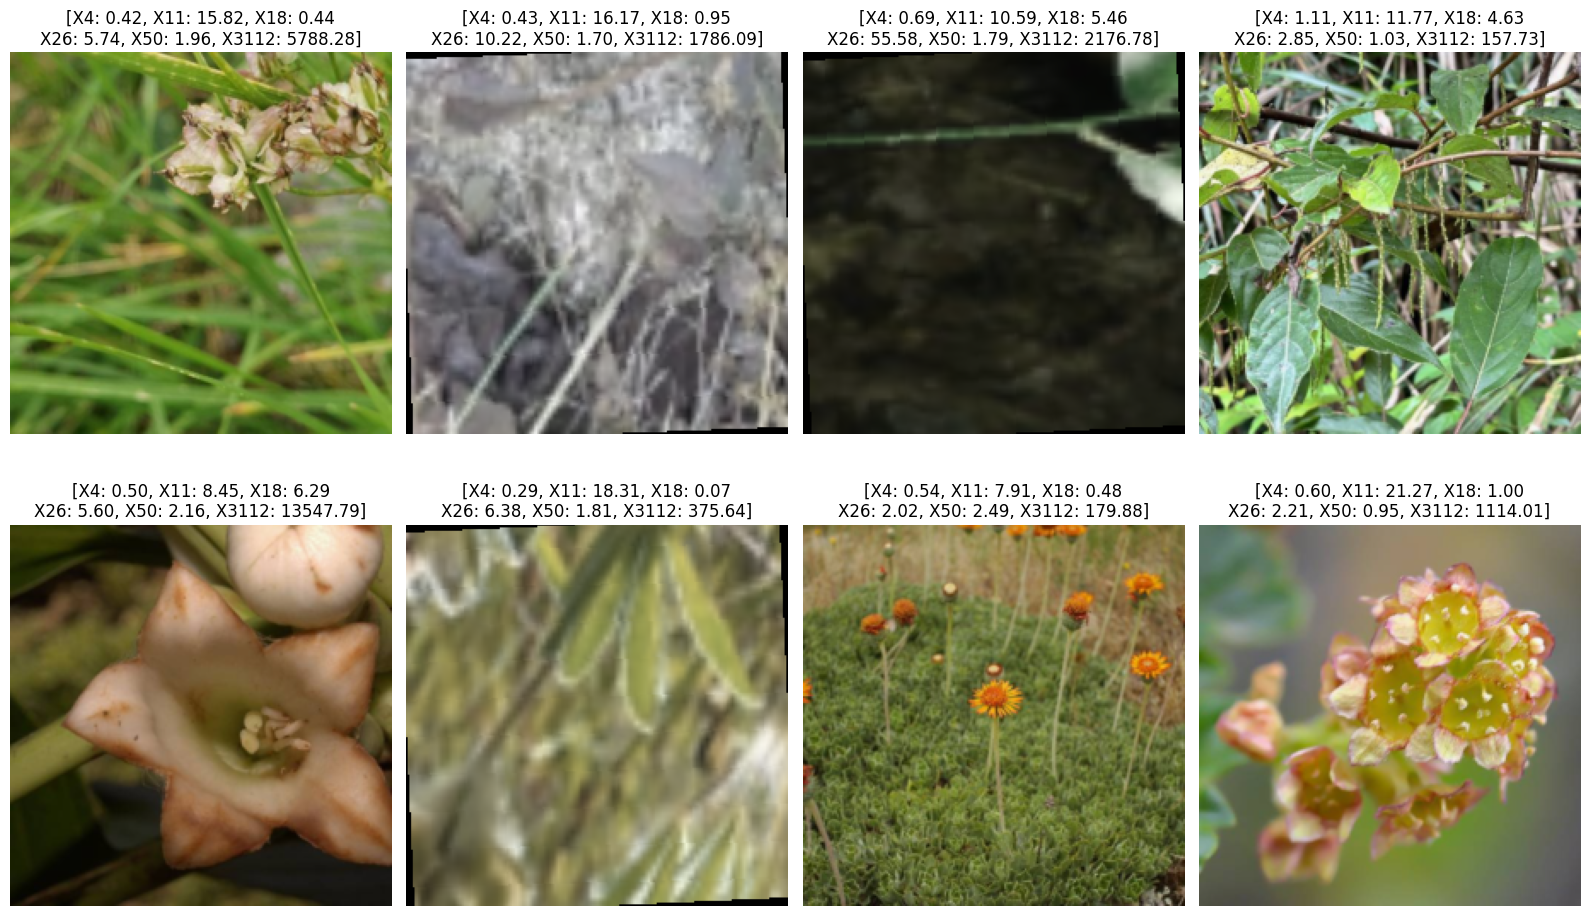

In [7]:
inps, tars = next(iter(train_ds))

imgs = inps["images"]
num_imgs, num_cols = 8, 4

plt.figure(figsize=(4 * num_cols, num_imgs // num_cols * 5))
for i, (img, tar) in enumerate(zip(imgs[:num_imgs], tars[0][:num_imgs])):
    plt.subplot(num_imgs // num_cols, num_cols, i + 1)

    img = img.permute(1, 2, 0)  # Change (C, H, W) to (H, W, C)
    
    img = img.numpy()
    tar = tar.numpy()
    
    img = (img - img.min()) / (img.max() + 1e-4)

    formatted_tar = "\n".join(
        [
            ", ".join(
                f"{name.replace('_mean','')}: {val:.2f}"
                for name, val in zip(CFG.class_names[j : j + 3], tar[j : j + 3])
            )
            for j in range(0, len(CFG.class_names), 3)
        ]
    )


    plt.imshow(img)
    plt.title(f"[{formatted_tar}]")
    plt.axis("off")

plt.tight_layout()
plt.show()

<h3>Define loss</h3>

In [20]:
import torch
import torchmetrics

class R2Loss(torch.nn.Module):
    def __init__(self, use_mask=False):
        super().__init__()
        self.use_mask = use_mask

    def forward(self, y_true, y_pred):
        if self.use_mask:
            mask = (y_true != -1)
            y_true = torch.where(mask, y_true, torch.zeros_like(y_true))
            y_pred = torch.where(mask, y_pred, torch.zeros_like(y_pred))
        SS_res = torch.sum((y_true - y_pred) ** 2, dim=0)
        SS_tot = torch.sum((y_true - y_true.mean(dim=0)) ** 2, dim=0)
        r2_loss = SS_res / (SS_tot + 1e-6)
        return r2_loss.mean()

class R2Metric(torchmetrics.Metric):
    def __init__(self):
        super().__init__(compute_on_step=False)
        self.add_state("SS_res", default=torch.zeros(6), dist_reduce_fx="sum")
        self.add_state("SS_tot", default=torch.zeros(6), dist_reduce_fx="sum")
        self.add_state("num_samples", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, y_true, y_pred):
        SS_res = torch.sum((y_true - y_pred) ** 2, dim=0)
        SS_tot = torch.sum((y_true - y_true.mean(dim=0)) ** 2, dim=0)
        self.SS_res.add_(SS_res)
        self.SS_tot.add_(SS_tot)
        self.num_samples.add_(y_true.shape[0])

    def compute(self):
        r2 = 1 - self.SS_res / (self.SS_tot + 1e-6)
        return r2.mean()

<h3>Construct model</h3>

In [21]:
import torch
from torch import nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

class INet(nn.Module):
    def __init__(self, feature_cols, num_classes, aux_num_classes):
        super(INet, self).__init__()
        self.backbone = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
        self.backbone.eval()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(1000, num_classes)

        self.dense1 = nn.Linear(len(feature_cols), 326)
        self.dense2 = nn.Linear(326, 64)
        self.dropout2 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(64, aux_num_classes)

    def forward(self, images, features):
        x1 = self.backbone(images)
        x1 = self.dropout1(x1)
        x1 = self.fc1(x1)

        features = features.to(torch.float32)
        x2 = nn.functional.selu(self.dense1(features))
        x2 = nn.functional.selu(self.dense2(x2))
        x2 = self.dropout2(x2)
        x2 = self.fc2(x2)

        return {"head": x1, "aux_head": x2}

In [22]:
model = INet(FEATURE_COLS, CFG.num_classes, CFG.aux_num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define your loss functions here
loss_fn_head = R2Loss()
loss_fn_aux_head = R2Loss()

dataloader = train_ds

# Training loop
for epoch in range(CFG.epochs):
    for inp, (out_features, labels) in tqdm(dataloader):
        images = inp["images"]
        features = inp["features"]
        optimizer.zero_grad()
        outputs = model(images, features)
        loss_head = loss_fn_head(outputs["head"], labels)
        loss_aux_head = loss_fn_aux_head(outputs["aux_head"], labels)
        loss = loss_head + 0.3 * loss_aux_head
        loss.backward()
        optimizer.step()

  0%|          | 0/2775 [00:00<?, ?it/s]

KeyboardInterrupt: 

<h3>LR scheduler</h3>

In [ ]:
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

In [ ]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

<h3>Training</h3>

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_head_r2",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb],
    steps_per_epoch=len(train_df) // CFG.batch_size,
    validation_data=valid_ds,
    verbose=CFG.verbose,
)

<h3>Results</h3>

In [ ]:
# Best Result
best_R2 = max(history.history['val_head_r2'])
best_Epoch = np.argmax(history.history['val_head_r2']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best R2: {best_R2:.5f}")
print(f"Best Epoch: {best_Epoch}")
print("#" * 28)

In [ ]:
model.load_weights("best_model.keras")

In [ ]:
# Test
test_paths = test_df.image_path.values
test_features = scaler.transform(test_df[FEATURE_COLS].values) 
test_ds = build_dataset(test_paths, test_features, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

In [ ]:
preds = model.predict(test_ds)["head"]

In [ ]:
pred_df = test_df[["id"]].copy()
target_cols = [x.replace("_mean","") for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

pred_df.to_csv("submission.csv", index=False)
pred_df.head()